# Electrical Distribution Network Energy Consumption Forecasting based upon Victorian MRIM Meter Data

In this notebook, the Energy Consumption from CitiPower will be forecasted based on Historical Data using ARIMA. 



# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Reading into the Data

In [2]:
data = pd.read_csv('citipower.csv')

# EDA

In [3]:
data.head()

,SETTD,DAILYT
0,2014-04-01,6363749.701
1,2014-04-02,5630825.535
2,2014-04-03,5173891.385
3,2014-04-04,5044050.180
4,2014-04-05,4383318.300


In [4]:
data.columns

Index(['SETTD', 'DAILYT'], dtype='object')

In [5]:
data.dtypes

SETTD      object
DAILYT    float64
dtype: object

# Setting Date as its index

In [6]:
data['SETTD'] = pd.to_datetime(data['SETTD'], dayfirst = True)

In [7]:
data = data.set_index('SETTD')

In [8]:
sum(data.isnull().sum())

0

Text(0, 0.5, 'Energy Consumption (kWh)')

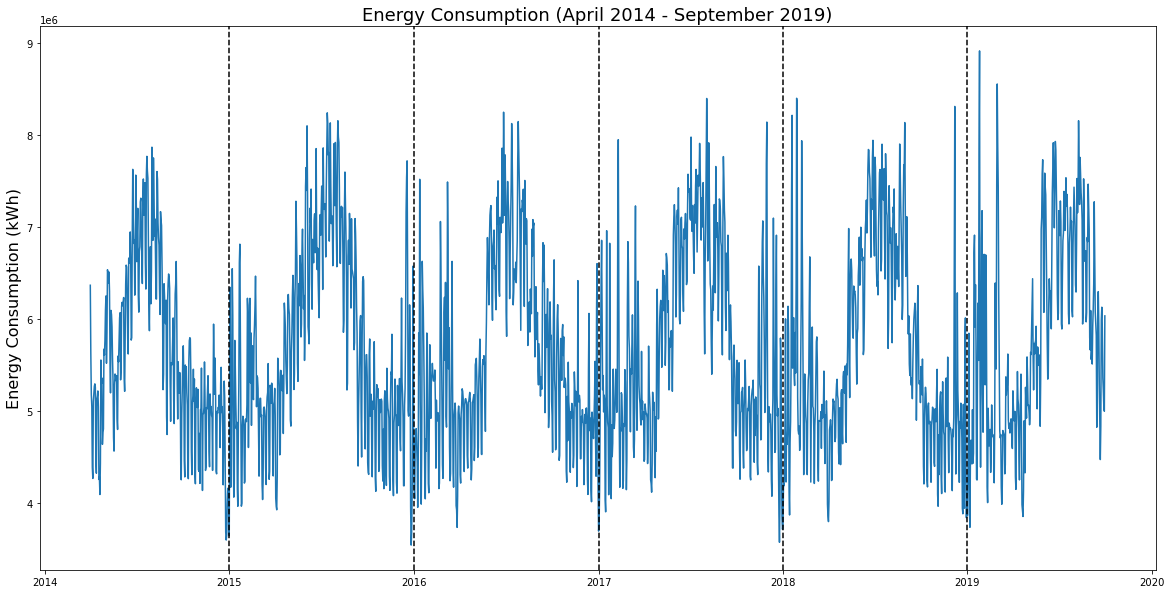

In [9]:
plt.figure(figsize = (20,10))
plt.plot(data)
for year in range(2015,2020):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--')
plt.title('Energy Consumption (April 2014 - September 2019)', fontsize = 18)
plt.ylabel('Energy Consumption (kWh)', fontsize = 16)

# Seasonal Decomposition

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

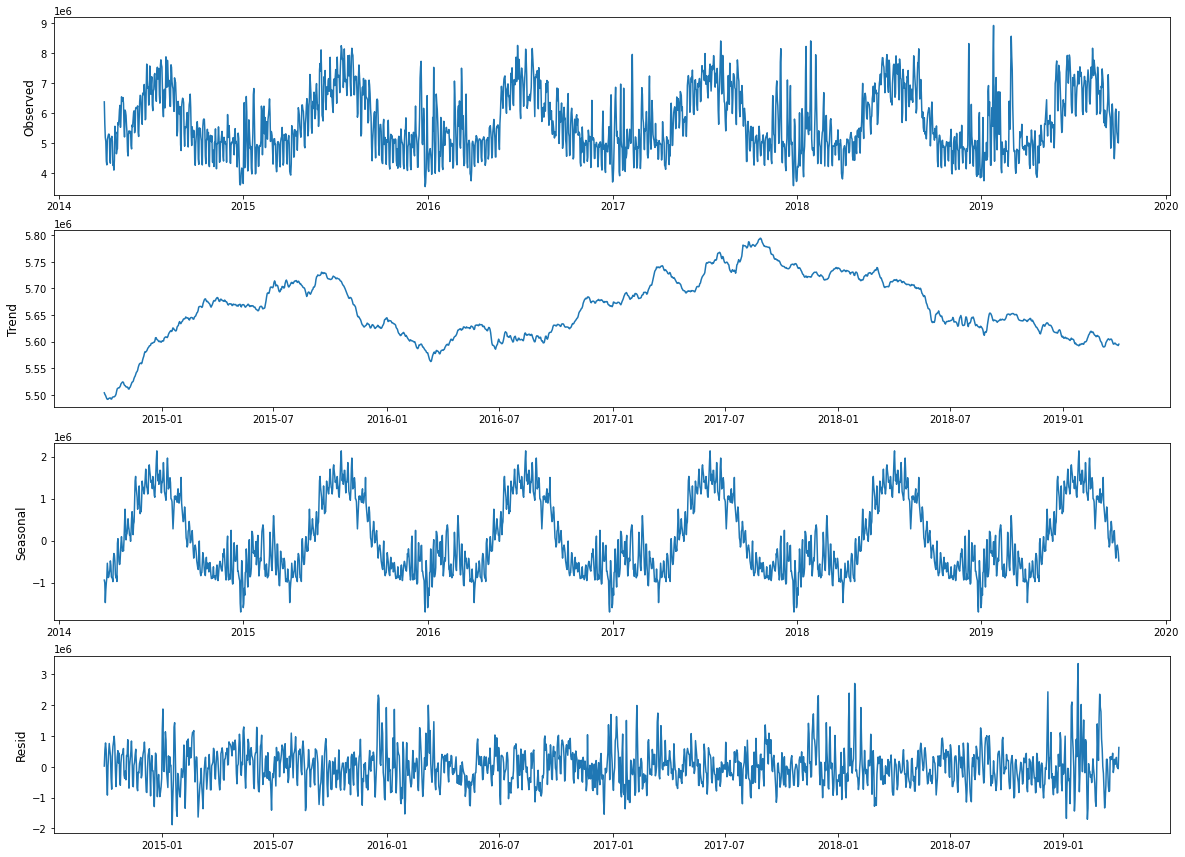

In [11]:
decomp = seasonal_decompose(data, period = 365)
trend = decomp.trend
seasonal = decomp.seasonal
resid = decomp.resid

plt.figure(figsize = (20,15))
plt.subplot(411)
plt.plot(data)
plt.ylabel('Observed', fontsize = 12)
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend', fontsize = 12)
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonal', fontsize = 12)
plt.subplot(414)
plt.plot(resid)
plt.ylabel('Resid', fontsize = 12)
plt.show()

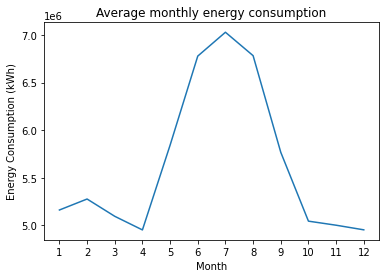

In [12]:
data.groupby(data.index.month).DAILYT.mean().plot()
plt.xlabel('Month')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Average monthly energy consumption')
plt.xticks(range(1,13))
plt.show()

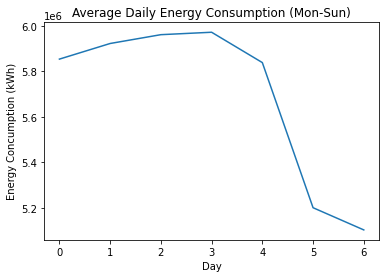

In [13]:
data.groupby(data.index.weekday).DAILYT.mean().plot()
plt.xlabel('Day')
plt.ylabel('Energy Concumption (kWh)')
plt.title('Average Daily Energy Consumption (Mon-Sun)')
plt.show()

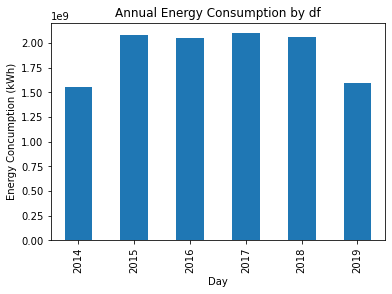

In [14]:
data.groupby(data.index.year).DAILYT.sum().plot(kind = 'bar')
plt.xlabel('Day')
plt.ylabel('Energy Concumption (kWh)')
plt.title('Annual Energy Consumption by df')
plt.show()

Reminder:<br>
- data in 2014 is between April and Dec
- data in 2019 is between January till end of September

# Split Train/Test

The objective is to predict the energy consumption in 2019.

In [15]:
train = data[data.index.year != 2019]
test = data[data.index.year == 2019]

# Checking Stationarity

## Dickey-Fuller Test

The Dickey-Fuller test is a type of hypothesis testing to determine whether the df is either stationary or non-stationary. <br>
- If the p_value is less than 0.5, reject the null hypothesis and the df is stationary.
- If the p_value is more than 0.5, accept the null hypothesis and the df is non-stationary.

In [16]:
from statsmodels.tsa.stattools import adfuller

In [17]:
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.200387
p-value: 0.019962
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


Since the p-value is less than 0.05, the null hypothesis is rejected. Therefore, the data is stationary. 

d = 0 for ARIMA parameter.

# ARIMA model

The performance of the ARIMA model will be used as a baseline model.

In [18]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5, 0, 'Lag (Days)')

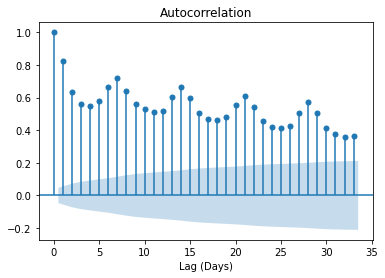

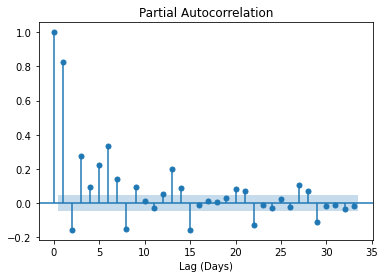

In [19]:
# Plotting autocorrelation function
plot_acf(train)
plt.xlabel('Lag (Days)')
plot_pacf(train)
plt.xlabel('Lag (Days)')

From the autocorrelation and partial autocorrelation plots above, the order for ARIMA is (1,0,0).

In [20]:
from statsmodels.tsa.arima_model import ARIMA
import itertools

In [21]:
p = q = range(0,4)
d = range(0,2)
pdq = list(itertools.product(p,d,q))

In [22]:
len(pdq)

32

In [23]:
# Determine the best param with the smallest AIC
best_param = []
aic = []
working_order = []
i = 0
best_aic = 10000000
for param in pdq:
    try:
        model = ARIMA(train, order = param, freq = 'D')
        results = model.fit(trend = 'nc')
        working_order.append(param)
        aic.append(results.aic)
        if results.aic < best_aic:
            best_param = param
            best_aic = results.aic
    except:
        continue

arima_order = pd.DataFrame({'order':working_order, 'AIC':aic})
print('ARIMA{}   AIC:{}'.format(best_param, best_aic))

ARIMA(3, 1, 3)   AIC:50595.71353753245


In [24]:
arima_order

,order,AIC
0,"(0, 0, 1)",56727.398215
1,"(0, 0, 2)",55119.624886
2,"(0, 0, 3)",53993.037914
3,"(0, 1, 1)",51114.693596
4,"(0, 1, 2)",50684.806902
5,"(0, 1, 3)",50633.865533
6,"(1, 0, 0)",51159.374866
7,"(1, 0, 1)",51144.205171
8,"(1, 0, 2)",50720.293352
9,"(1, 0, 3)",50669.388536


In [25]:
arima_model = ARIMA(train, (1,0,0), freq = 'D').fit()

In [26]:
# From the gird search
arima_model_gs = ARIMA(train, (3,1,3), freq = 'D').fit()

In [27]:
print(arima_model.summary())

                              ARMA Model Results                              
Dep. Variable:                 DAILYT   No. Observations:                 1736
Model:                     ARMA(1, 0)   Log Likelihood              -25500.323
Method:                       css-mle   S.D. of innovations         579461.951
Date:                Thu, 17 Sep 2020   AIC                          51006.647
Time:                        13:12:21   BIC                          51023.025
Sample:                    04-01-2014   HQIC                         51012.704
                         - 12-31-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.669e+06   8.04e+04     70.486      0.000    5.51e+06    5.83e+06
ar.L1.DAILYT     0.8276      0.013     61.438      0.000       0.801       0.854
                                    Roots   

In [28]:
predict_arima_daily = arima_model.forecast(steps = 273) 
predict_arima_gs = arima_model_gs.forecast(steps = 273)

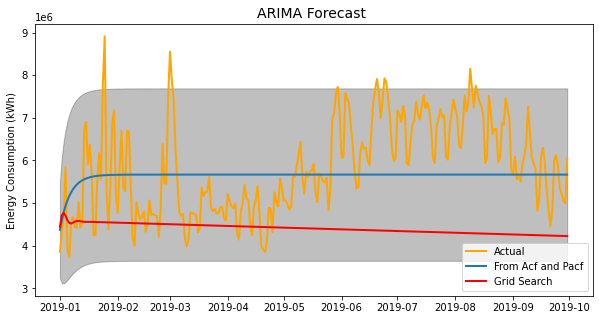

In [29]:
plt.figure(figsize=(10,5))
plt.fill_between(test.index, predict_arima_daily[-1][:,1], predict_arima_daily[-1][:,0], 
                 alpha = 0.25, color = 'black')
plt.plot(test, linewidth = 2, color = 'orange', label = 'Actual')
plt.plot(test.index, predict_arima_daily[0], linewidth = 2, label = 'From Acf and Pacf')
plt.plot(test.index, predict_arima_gs[0], linewidth = 2, color = 'r', label = 'Grid Search')
plt.title('ARIMA Forecast ', fontsize = 14)
plt.legend(loc = 'lower right')
plt.ylabel('Energy Consumption (kWh)')

plt.show()

From the graph above, the parameters determined from the acf and the pacf plots seems to perform better. However, neither of them captures the seasonal component of the data.

# Walk-Forward Validation

In [30]:
# walk-forward validation
train = data.iloc[:(len(data)-273)]['DAILYT']
test = data.iloc[(len(data)-273):]['DAILYT']
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    model = ARIMA(history, order=(1,0,0)) #(1,0,0)
    model_fit = model.fit()
    #Array containing the forecast value, the standard error of the forecast, and the confidence interval information.
    #Only interested in the 1st element
    yhat = model_fit.forecast()[0] #Forecasting the next step
    predictions.append(yhat)
    # observation
    obs = test[i]    #Actual data on this day
    history.append(obs)

In [31]:
a = pd.DataFrame(test)
b = pd.DataFrame(predictions)
b.set_index(test.index, inplace = True)
compare = pd.concat([a,b],axis = 1)
compare.columns = ['Actual', 'Predict']
compare.head()

,Actual,Predict
SETTD,,
2019-01-01,3858957.991,4.373397e+06
2019-01-02,4264155.819,4.170141e+06
2019-01-03,4690920.697,4.505632e+06
2019-01-04,5841792.852,4.858990e+06
2019-01-05,3913922.670,5.811564e+06


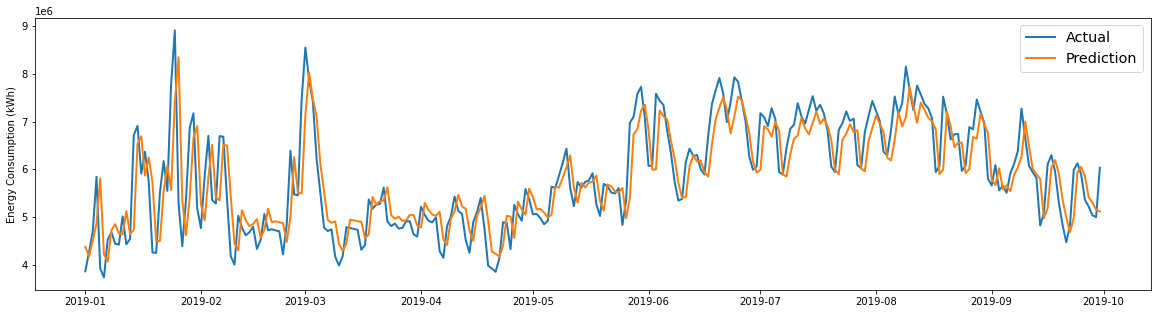

In [32]:
plt.figure(figsize = (20,5))
plt.plot(compare['Actual'], label = 'Actual', linewidth = 2)
plt.plot(compare['Predict'], label = 'Prediction', linewidth = 2)
plt.ylabel('Energy Consumption (kWh)')
plt.legend(fontsize = 'x-large')

# Performance Evaluation

In [33]:
from sklearn.metrics import r2_score
#############################################
#         evaluation function by AMMAR      #
#############################################
# Evaluation metrics
# MAPE mean_absolute_percentage_error
def regMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1.))) * 100


# print_error
def regPrintErr(y_true, y_pred):
    print('R2 Score: {}'.format(r2_score(y_true, y_pred)))
    print('MAPE: {}'.format(regMAPE(y_true, y_pred)))

In [34]:
print('ARIMA (1,0,0)')
regPrintErr(test.values, predict_arima_daily[0])

ARIMA (1,0,0)
R2 Score: 0.008546395647728078
MAPE: 15.726673398908714


In [35]:
print('ARIMA (3,1,3)')
regPrintErr(test.values, predict_arima_gs[0])

ARIMA (3,1,3)
R2 Score: -1.7960614612447783
MAPE: 23.3793775143434


In [36]:
print('ARIMA (1,0,0) - Walk-Forward')
regPrintErr(compare['Actual'], compare['Predict'])

ARIMA (1,0,0) - Walk-Forward
R2 Score: 0.6767524163857603
MAPE: 7.940062376614102


In [37]:
results = {'Actual': test.values, 'ARIMA':predict_arima_daily[0], 
         'ARIMA (Walk-Forward)': compare['Predict']}

The model evaluations are performed in 'Model Evaluation' notebook.

In [38]:
results_ARIMA = pd.DataFrame(results)

In [39]:
results_ARIMA.head()

,Actual,ARIMA,ARIMA (Walk-Forward)
SETTD,,,
2019-01-01,3858957.991,4.373397e+06,4.373397e+06
2019-01-02,4264155.819,4.596834e+06,4.170141e+06
2019-01-03,4690920.697,4.781742e+06,4.505632e+06
2019-01-04,5841792.852,4.934764e+06,4.858990e+06
2019-01-05,3913922.670,5.061398e+06,5.811564e+06


In [40]:
results_ARIMA.to_csv('results_ARIMA.csv')